Testing the voting scheme on a -ve mode file

In [20]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
files = []

prefix = '/Users/simon/Dropbox/Bioresearch/Meta_clustering/ms1fundata/Beer/NegativeMode/Beer_3_full/csv/'
filename = 'Beer_3_Full1'
files.append((prefix,filename,False))

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/neg/csv/'
filename = 'Urine_37_fullscan1_NEG'
files.append((prefix,filename,False))

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/neg/csv/'
filename = 'batch1_Std_1_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_1_2'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_2'
files.append((prefix,filename,True))


In [22]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/neg_transformations.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 72 transformations


In [23]:
bl = BetaLike()
clusterings = {}
for f in files:

    filename = f[1]
    prefix = f[0]
    print "Running file " + filename
    csvfile = prefix + filename + '.csv'
    matfile = prefix + filename + '.corr.mat'
    signalfile = prefix + filename + '.peakml.signal'
    # Simon is an idiot...remember to change 'correct = True' or 'correct = False' 
    # coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=True)
    coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=f[2])
    clusterings[filename] = coc

Running file Beer_3_Full1
1356.4
Loaded 5668 peaks
Reading shape correlations from /Users/simon/Dropbox/Bioresearch/Meta_clustering/ms1fundata/Beer/NegativeMode/Beer_3_full/csv/Beer_3_Full1.corr.mat
Greedy clustering done, resulting in 947 clusters
Running file Urine_37_fullscan1_NEG
138
Loaded 6662 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/neg/csv/Urine_37_fullscan1_NEG.corr.mat
Greedy clustering done, resulting in 1128 clusters
Running file batch1_Std_1_1
1391.708618164
Loaded 5618 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/neg/csv/batch1_Std_1_1.corr.mat
Greedy clustering done, resulting in 1454 clusters
Running file batch1_Std_1_2
Loaded 5736 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/neg/csv/batch1_Std_1_2.corr.mat
Greedy clustering done, resulting in 1442 clusters
Running file batch1_Std_2_1

In [24]:
from voter import Voter,PeakGroup
groups = {}
for f in files:
    v = Voter(transformations)
    filename = f[1]
    print "Performing voting on file {}".format(filename)
    file_groups = []
    for cluster in clusterings[filename].clusters:
        file_groups += v.make_groups(cluster.members)
    groups[filename] = file_groups

Performing voting on file Beer_3_Full1
Performing voting on file Urine_37_fullscan1_NEG
Performing voting on file batch1_Std_1_1
Performing voting on file batch1_Std_1_2
Performing voting on file batch1_Std_2_1
Performing voting on file batch1_Std_2_2


In [25]:
PROTON = 1.00727645199076


class Mol(object):
    def __init__(self,name,formula,mass,rt):
        self.name = name.strip()
        self.formula = formula.strip()
        self.mass = mass
        self.rt = rt
    def __str__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)
    def __repr__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)

In [26]:
std_file = base_dir + 'dbs/std1_20130822_130526.csv'
std_file = '/Users/simon/Downloads/Beer3_mzXML_mzML_files/Std1_1_20150422_150810_combined.csv'
mols = []
with open(std_file,'rU') as f:
    for i in range(9):
        f.readline() # remove heads
    for line in f:
        split_line = line.split(',')
        polarity = split_line[4]
        rts = split_line[9] # observed, not predicted
        if rts == '-':
            rt = 0.0
        else:
            rt = float(rts)
        if polarity == '+' and rt > 0.0:
            name = split_line[2]
            formula = split_line[3]
            f = Formula(formula)
            new_mol = Mol(name,formula,f.compute_exact_mass(),rt*60.0)
            mols.append(new_mol)
mols = sorted(mols,key = lambda x: x.mass)
for mol in mols:
    print mol

1_3-Diaminopropane (74.0843983319,738.6)
Glycine (75.0320284101,658.8)
1-Aminopropan-2-ol (75.0684139166,938.4)
Mercaptoethanol (78.0139355049,1307.4)
beta-Alanine (89.0476784744,646.2)
L-Alanine (89.0476784744,633.6)
Glycerol (92.0473441234,480.0)
Phenol (94.0418648149,250.8)
1-Aminocyclopropane-1-carboxylate (101.047678474,569.4)
2-Aminobutan-4-olide (101.047678474,379.8)
4-Aminobutanoate (103.063328539,649.2)
Choline (103.099714045,915.0)
L-2_3-Diaminopropanoate (104.058577512,654.6)
L-Serine (105.042593097,657.6)
Phenylhydrazine (108.068748268,301.8)
cytosine (111.043261799,552.6)
Uracil (112.027277383,463.2)
Creatinine (113.058911863,496.8)
L-Proline (115.063328539,580.8)
Selenomethionine (117.078978603,538.8)
L-Valine (117.078978603,570.6)
Betaine (117.078978603,534.6)
L-2_4-Diaminobutanoate (118.074227576,743.4)
L-Threonine (119.058243161,619.2)
L-homoserine (119.058243161,637.8)
L-cysteine (121.019749164,612.6)
Nicotinamide (122.048012825,400.8)
Nicotinate (123.03202841,412.2)


In [27]:
def hit(m1,m2,rt1,rt2,mtol=20,rttol=1):
    if 1e6*np.abs(m1-m2)/m2 < mtol and np.abs(rt1-rt2)<rttol:
        return True
    else:
        return False
    
def get_hits(peaks,mols,transformations,mtol=20,rttol = 120.0):
    hits = {}
    for mol in mols:
        for peak in peaks:
            for t in transformations:
                if hit(t.transform(peak),mol.mass,peak.rt,mol.rt,mtol = mtol,rttol = rttol):
                    if mol in hits:
                        if np.abs(peak.rt - mol.rt) < np.abs(hits[mol].rt - mol.rt):
                            hits[mol] = peak
                    else:
                        hits[mol] = peak
    return hits

In [28]:
def get_M_hits(groups,mols,use_max_vote = True):
    hits = {}
    for g in groups:
        for mol in mols:
            if hit(mol.mass,g.M,mol.rt,g.rt,mtol=10,rttol=10):
                if not mol in hits:
                    hits[mol] = g
                else:
                    if use_max_vote:
                        if g.vote > hits[mol]:
                            hits[mol] = g
                    else:
                        current = hits[mol]
                        if np.abs(g.rt - mol.rt) < np.abs(current.rt - mol.rt):
                            hits[mol] = g
                
    return hits

In [29]:
all_hits = {}
for f in files:
    filename = f[1]
    all_hits[filename] = get_M_hits(groups[filename],mols,use_max_vote = True)

    

In [32]:
# Sort the groups according to votes (top ones first)
global_adduct_counts = {}
global_transformation_counts = {}
global_fragment_counts = {}
for f in files:
    filename = f[1]
    outpre = 'output/neg/' + filename

    temp_groups = sorted(groups[filename],key = lambda x:x.vote,reverse=True)
    outfile = outpre + '_by_vote.txt'
    

    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')
            
    temp_groups = sorted(groups[filename],key = lambda x:x.M)
    outfile = outpre + '_by_M.txt'
    
    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')

    with open(outpre + '_matched_std.txt','w') as f:
        for mol in all_hits[filename]:
            group = all_hits[filename][mol]
            line = "{} (vote={})\n".format(mol,group.vote)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')


    include_singletons = False
    trans_counts = {}
    tot = 0
    for tr in transformations:
        trans_counts[tr] = 0
    for group in groups[filename]:
        if not include_singletons:
            if len(group.members) == 1:
                continue
        for p,t,_ in group.members:
            trans_counts[t] += 1
            tot += 1

    with open(outpre + '_tran_counts.txt','w') as f:
        for tr in sorted(transformations,key = lambda x: x.vote, reverse=True):
            line = "{},{},{:.4f}\n".format(tr,trans_counts[tr],trans_counts[tr]/(1.0*tot))
            f.write(line)
            
    # output the counts of particular adducts / fragments
    frag_counts = {}
    adduct_counts = {}
    adduct_tot = 0
    frag_tot = 0
    for tr in transformations:
        for f in tr.fragments:
            if not f in frag_counts:
                frag_counts[f] = 0
        for a in tr.adducts:
            if not a in adduct_counts:
                adduct_counts[a] = 0
                
    for group in groups[filename]:
        for p,t,_ in group.members:
            for f in t.fragments:
                frag_counts[f] += 1
                frag_tot += 1
            for a in t.adducts:
                adduct_counts[a] += 1
                adduct_tot += 1
                
    global_adduct_counts[filename] = adduct_counts
    global_fragment_counts[filename] = frag_counts
    global_transformation_counts[filename] = trans_counts
                
    with open(outpre + '_adduct_counts.txt','w') as f:
        for a in adduct_counts:
            line = "{},{},{:.4f}\n".format(a,adduct_counts[a],adduct_counts[a]/(1.0*adduct_tot))
            f.write(line)
    
    with open(outpre + '_fragment_counts.txt','w') as f:
        for fr in frag_counts:
            line = "{},{},{:.4f}\n".format(fr,frag_counts[fr],frag_counts[fr]/(1.0*frag_tot))
            f.write(line)

            

Write out files of global adducts, fragments and transformations, to save excel wrangling

In [53]:
# Note this just does percentages
# Note 2 - for fragments, this is normalised according to things that have fragments
all_frags = []
for fi in global_fragment_counts:
    frags = global_fragment_counts[fi].keys()
    for fr in frags:
        if not fr in all_frags:
            all_frags.append(fr)

all_files = global_fragment_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for fr in global_fragment_counts[filename]:
        tot += global_fragment_counts[filename][fr]
    totals[filename] = tot
            
with open('output/neg/global_frags.txt','w') as f:
    st = "Fragment"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for fr in all_frags:
        st = fr
        for filename in all_files:
            st += ",{}".format(global_fragment_counts[filename][fr]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        

        
# ADDUCTS
all_adducts = []
for files in global_adduct_counts:
    adds = global_adduct_counts[files].keys()
    for ad in adds:
        if not ad in all_adducts:
            all_adducts.append(ad)

all_files = global_adduct_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for ad in global_adduct_counts[filename]:
        tot += global_adduct_counts[filename][ad]
    totals[filename] = tot
            
with open('output/neg/global_adducts.txt','w') as f:
    st = "Adduct"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for ad in all_adducts:
        st = ad
        for filename in all_files:
            st += ",{}".format(global_adduct_counts[filename][ad]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        
        
# TRANSFORMATIONS
all_trans = []
for files in global_transformation_counts:
    adds = global_transformation_counts[files].keys()
    for tr in adds:
        if not tr in all_trans:
            all_trans.append(tr)

all_files = global_transformation_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for tr in global_transformation_counts[filename]:
        tot += global_transformation_counts[filename][tr]
    totals[filename] = tot
            
with open('output/neg/global_transformations.txt','w') as f:
    st = "Transformation"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for tr in sorted(all_trans,key = lambda x: x.vote,reverse=True):
        st = tr.name
        for filename in all_files:
            st += ",{}".format(global_transformation_counts[filename][tr]/(1.0*totals[filename]))
        f.write(st+'\n')

Find the counts of particular fragments

In [15]:
frag_counts = {}
adduct_counts = {}
tot = 0
for tr in transformations:
    if len(tr.fragments)>0:
        if not tr.fragments[0] in frag_counts:
            frag_counts[tr.fragments[0]] = 0
    for a in tr.adducts:
        if not a in adduct_counts:
            adduct_counts[a] = 0

filename = files[0][1]
for group in groups[filename]:
    for p,t,_ in group.members:
        if len(t.fragments)>0:
            frag_counts[t.fragments[0]] += 1
        for a in t.adducts:
            adduct_counts[a] += 1

In [16]:
print frag_counts,adduct_counts


{'H2O': 281, 'CO2': 303, 'CO': 234} {'CH2O2': 263, '-H': 5791, 'NH3': 132, 'ACN': 182}


In [61]:
import formula
glycine = formula.Formula('C2H5NO2')
print glycine.compute_exact_mass()

75.0320284101


In [63]:
pro = [a for a in transformations if a.name == 'M-H'][0]

In [82]:
tr = [pro]
h = get_hits(clusterings[files[0][1]].peaks,mols,tr,rttol = 120)

In [83]:
true = []
pe = []
for m in h:
    true.append(m.rt)
    pe.append(h[m].rt)

52


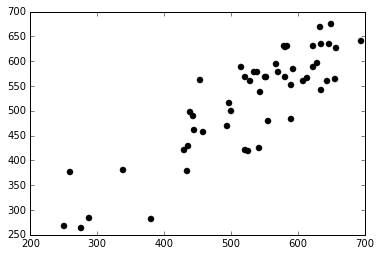

In [84]:
plt.plot(true,pe,'ko')
print len(true)